In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from IPython.display import display, clear_output

### Outline
Second pass at assessing photosynthesis across bacterial genomes. Forget that machine learning BS, here's the approach:
1. Figure out the Pfams which correspond to chlorophyll-associated genes using MetaCyc pathway definitions
2. Subset GTDB genomes to genomes which contain these genes using pre-compiled Pfam data
3. Run gapseq on chlorophyll biosynthesis pathways (from MetaCyc)





### Defining Pfams used for initial screening of genomes
By manually searching for EC number in InterProScan / Pfam database. The list of EC numbers was obtained by:
1. Getting GO terms for chlorophyll biosynthetic process or photosynthesis
2. Getting pfam to GO mapping from http://current.geneontology.org/ontology/external2go/pfam2go


In [2]:
pfam2go = pd.read_csv('/data/mhoffert/db/pfam/pfam2go.txt', skiprows=6, sep=' > ', header=None, engine='python')

In [3]:
pfam2go['Pfam'] = pfam2go[0].apply(lambda x: x.split(':')[-1].split(' ')[0])
pfam2go['GO'] = pfam2go[1].apply(lambda x: x.split(' ; ')[-1])
pfam2go.head()

,0,1,Pfam,GO
0,Pfam:PF00001 7tm_1,GO:G protein-coupled receptor activity ; GO:00...,PF00001,GO:0004930
1,Pfam:PF00001 7tm_1,GO:G protein-coupled receptor signaling pathwa...,PF00001,GO:0007186
2,Pfam:PF00001 7tm_1,GO:membrane ; GO:0016020,PF00001,GO:0016020
3,Pfam:PF00002 7tm_2,GO:G protein-coupled receptor activity ; GO:00...,PF00002,GO:0004930
4,Pfam:PF00002 7tm_2,GO:G protein-coupled receptor signaling pathwa...,PF00002,GO:0007186


In [4]:
go_terms = ['GO:0015995', 'GO:1902326', 'GO:0036068', 'GO:00333005', 'GO:0030494', 'GO:0010380', 'GO:1902325', 'GO:0036067',
            'GO:0015979', 'GO:0019684', 'GO:0019685', 'GO:0010109', 'GO:1905157', 'GO:0009521', 'GO:1905156', 'GO:0034357']
pfam_terms = pfam2go[pfam2go['GO'].isin(go_terms)]['Pfam'].unique()
print(f'{len(pfam_terms)} Pfams found')

48 Pfams found


In [17]:
print(', '.join(go_terms))

GO:0015995, GO:1902326, GO:0036068, GO:00333005, GO:0030494, GO:0010380, GO:1902325, GO:0036067, GO:0015979, GO:0019684, GO:0019685, GO:0010109, GO:1905157, GO:0009521, GO:1905156, GO:0034357


### Testing out PFam usage on known phototrophs
Start by assembling list of phototrophic organisms

In [7]:
# metadata for GTDB genomes
gtdb_md = pd.read_csv('/data/mhoffert/genomes/GTDB_r207/bac120_metadata_r207.tsv', sep='\t', index_col=0)

Columns (61,65,74,82,83,85) have mixed types. Specify dtype option on import or set low_memory=False.


In [8]:
gtdb_reps_md = gtdb_md[gtdb_md.gtdb_representative.eq('t')]

taxonomy_levels = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
gtdb_taxonomy = gtdb_reps_md.gtdb_taxonomy.apply(lambda x: pd.Series(index=taxonomy_levels,
                                                            data=[s.split('_')[-1] for s in x.split(';')]))

In [9]:
# Chlorotrophic organisms 
sheets = []
for i in range(6):
    if i < 6:
        skiprows=1
    else:
        skiprows=0
    sheet = pd.read_excel('/data/mhoffert/fiererlab/periodic_phyla/data/PP69_Bryant_Supplemental_Table3.xlsx', skiprows=skiprows, sheet_name=i)
    sheet = sheet.rename(columns={'organism_name':'Organism name',
                                  'Organism_name':'Organism name'})
    sheets.append(sheet)
    

In [10]:
chlorophototrophic_organisms = pd.concat(sheets, axis=0)[['GenBank Assembly ID (Accession.version)', 'Organism name']].rename(columns={'GenBank Assembly ID (Accession.version)':'genbank_acc', 
                                             'Organism name':'name'})

In [11]:
# make a list of the chlorophototrophic organisms
phototroph_list = []
# use genbank accessions
for index, row in gtdb_md[gtdb_md.ncbi_genbank_assembly_accession.isin(chlorophototrophic_organisms.genbank_acc.values)].iterrows():
    # only append GTDB representative genomes
    if row['gtdb_representative'] == 't':
        phototroph_list.append(index)
    else:
        phototroph_list.append(row['gtdb_genome_representative'])

In [12]:
# unique the list
phototroph_list = list(set(phototroph_list))

### Loading pfam data

In [13]:
all_pfam_data = pd.read_csv('/data/mhoffert/genomes/GTDB_r207/gtdb_genomes_reps_r207_pfam_trusted.tsv.gz', sep='\t', compression='gzip', index_col=0)

### Analysis

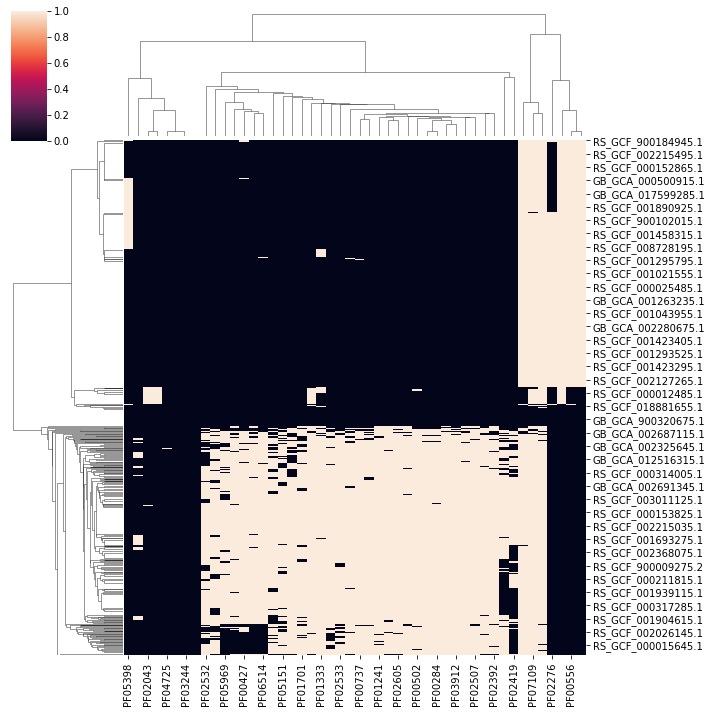

In [14]:
sns.clustermap(all_pfam_data.loc[phototroph_list, pfam_terms])

In [75]:
chloroflexia = gtdb_md[gtdb_md['gtdb_taxonomy'].str.contains('p__Chloroflexota') & 
                        gtdb_md['gtdb_representative'].eq('t') & 
                        gtdb_md['gtdb_taxonomy'].str.contains('c__Chloroflexia')].index

non_chloroflexia = gtdb_md[gtdb_md['gtdb_taxonomy'].str.contains('p__Chloroflexota') & 
                        gtdb_md['gtdb_representative'].eq('t') & 
                        ~gtdb_md['gtdb_taxonomy'].str.contains('c__Chloroflexia')].index

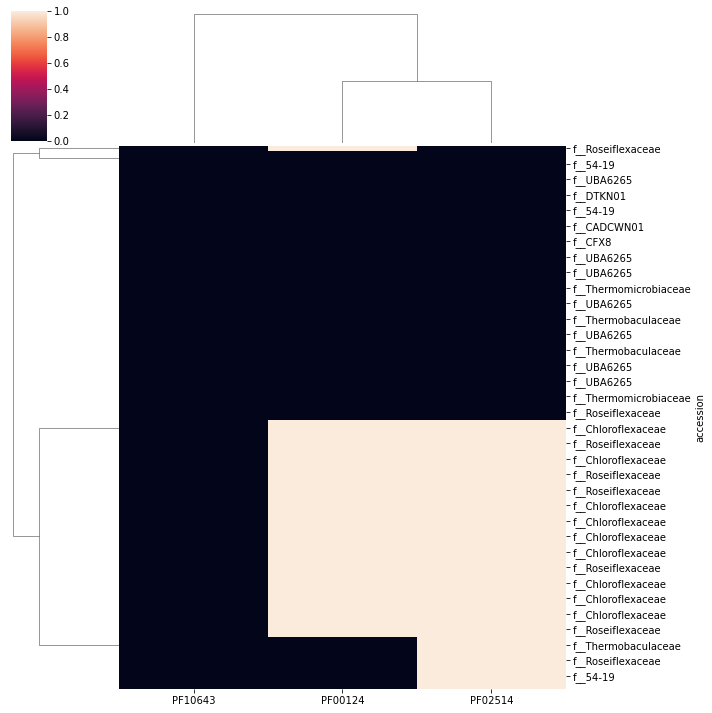

In [105]:
sns.clustermap(all_pfam_data.loc[chloroflexia, ['PF00124', 'PF02514', 'PF10643']].rename(index=gtdb_md.loc[chloroflexia, 'gtdb_taxonomy'].apply(lambda x: x.split(';')[4])))

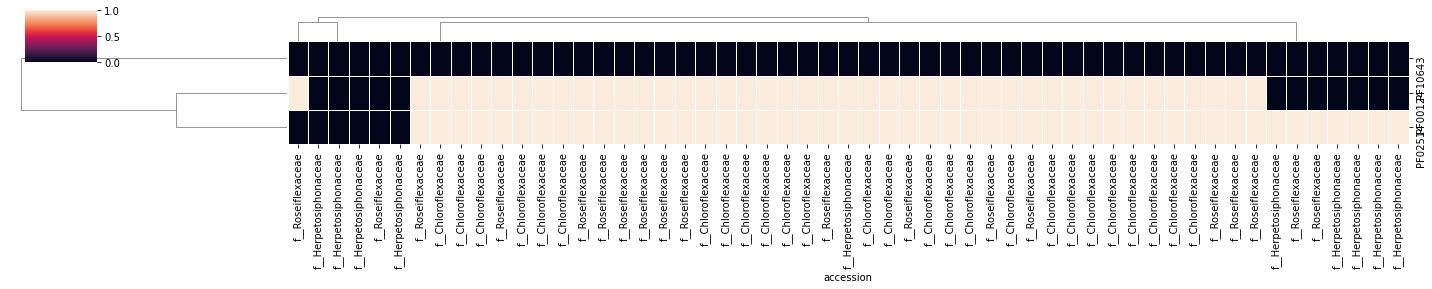

In [142]:
clustermap_data = all_pfam_data.loc[chloroflexia, ['PF00124', 'PF02514', 'PF10643']].rename(index=gtdb_md.loc[chloroflexia, 'gtdb_taxonomy'].apply(lambda x: x.split(';')[4])).T
sns.clustermap(clustermap_data, figsize=(20, 4), linewidth=1)

In [16]:
pfam_data = pd.read_csv('/data/mhoffert/db/pfam/pfamA.txt.gz', sep='\t', index_col=0, header=None)

In [17]:
'''
What are the 3 most prevalent pfams in phototrophs?
'''
top_pfams = (all_pfam_data.loc[phototroph_list, pfam_terms].sum() / len(phototroph_list)).sort_values(ascending=False).head(3).index
pfam_data.loc[top_pfams, :]

,1,2,3,4,5,6,7,8,9,10,...,34,35,36,37,38,39,40,41,42,43
PF08369,PCP_red,NaN,Proto-chlorophyllide reductase 57 kD subunit,anon,Pfam-B_2047 (release 18.0),Family,This domain is found in bacteria and plant chl...,32.5,32.5,32.5,...,CHANGED,Wos-ActpLcc.l....P.hFVR....spsRcpsEchApcpGhspl...,.......Wss-Ac....tcLc+.I....P.hFVR....s+sRcssE...,0,6388,1,185,618,1227,1820
PF07109,Mg-por_mtran_C,NaN,Magnesium-protoporphyrin IX methyltransferase ...,anon,Pfam-B_12015 (release 10.0),Family,This family represents the C-terminus (approxi...,27.0,27.0,37.5,...,CHANGED,ChDVLIHYPtschsphls+LuuhscspllhoFAP+TshLslh+tlG...,.....shDsLIHYspscssthlu+LAuhscppllhoFAP+ThhLsl...,0,1924,1,106,386,725,1070
PF00124,Photo_RC,photoRC;,Photosynthetic reaction centre protein,anon,Prosite,Family,NaN,27.0,27.0,27.1,...,CHANGED,hYlGaaGVholhhuhluhhllhhuhh.......s.sth...........,.................................................,0,42155,1,406,1288,2398,3465


In [26]:
(all_pfam_data.loc[phototroph_list, pfam_terms] > 0).sum(1).eq(0).sum()

24

In [23]:
gtdb_reps_md.loc['GB_GCA_001724995.1', 'gtdb_taxonomy']

'd__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Rubrivivax;s__Rubrivivax sp001724995'

In [171]:
'''
which phototrophs have none of the expected genes?
'''
low_gene_count_phototrophs = (all_pfam_data.loc[phototroph_list, pfam_terms].sum(1) / len(pfam_terms)).sort_values().head(50).index
gtdb_md.loc[low_gene_count_phototrophs, 'gtdb_taxonomy'].apply(lambda x: x.split(';')[-5]).value_counts()

c__Vampirovibrionia       17
c__Alphaproteobacteria    17
c__Chlorobia               7
c__Gammaproteobacteria     5
c__Sericytochromatia       2
c__Desulfitobacteriia      1
c__Cyanobacteriia          1
Name: gtdb_taxonomy, dtype: int64

In [172]:
phototroph_pfams = pfam_terms

### Examining the genomes containing at least one of these genes

In [173]:
num_phototrophs = (all_pfam_data.loc[:, phototroph_pfams].sum(1) > 0).sum()
print(num_phototrophs)

12906


In [180]:
gtdb_phototrophs = all_pfam_data.index[all_pfam_data.loc[:, phototroph_pfams].sum(1) > 0]
print(len(gtdb_phototrophs))

12906


In [181]:
gp_count = gtdb_md.loc[gtdb_phototrophs, 'gtdb_taxonomy'].apply(lambda x: x.split(';')[1]).value_counts()
for index, item in gp_count.iteritems():
    print(f"{index}: {item / gtdb_md['gtdb_taxonomy'].str.contains(index).sum() * 100:0.2f}%")

p__Proteobacteria: 2.05%
p__Bacteroidota: 11.38%
p__Cyanobacteria: 40.74%
p__Planctomycetota: 42.57%
p__Actinobacteriota: 2.16%
p__Acidobacteriota: 36.41%
p__Verrucomicrobiota: 18.61%
p__Desulfobacterota: 20.55%
p__Firmicutes_A: 1.91%
p__Chloroflexota: 15.18%
p__Firmicutes: 0.31%
p__Nitrospirota: 41.68%
p__Patescibacteria: 4.69%
p__Gemmatimonadota: 41.79%
p__Desulfobacterota_I: 41.83%
p__Omnitrophota: 34.54%
p__Firmicutes_B: 25.25%
p__Myxococcota: 13.73%
p__Deinococcota: 32.88%
p__Marinisomatota: 16.53%
p__Thermotogota: 31.58%
p__Spirochaetota: 3.00%
p__Methylomirabilota: 57.98%
p__Bdellovibrionota: 18.28%
p__Fusobacteriota: 15.53%
p__Nitrospinota: 52.25%
p__Aquificota: 44.86%
p__Firmicutes_C: 3.50%
p__Myxococcota_A: 31.90%
p__Armatimonadota: 14.34%
p__Dormibacterota: 19.88%
p__Fibrobacterota: 14.80%
p__Latescibacterota: 35.44%
p__Poribacteria: 50.00%
p__Bipolaricaulota: 33.77%
p__Elusimicrobiota: 7.99%
p__Zixibacteria: 37.10%
p__Hydrogenedentota: 41.82%
p__Eisenbacteria: 60.53%
p__Clo

#### Notes
Known phototrophs: Cyanobacteria (yes), Proteobacteria (yes), Chlorobi, Chloroflexi, Firmicutes, Acidobacteria, and Gemmatimonadetes

In [183]:
gtdb_phototrophs

Index(['RS_GCF_000024565.1', 'GB_GCA_002367695.1', 'GB_GCA_003167215.1',
       'RS_GCF_001632285.1', 'RS_GCF_000239695.1', 'RS_GCF_000008185.1',
       'RS_GCF_900457465.1', 'RS_GCF_000340475.1', 'GB_GCA_002480015.1',
       'GB_GCA_001029795.1',
       ...
       'GB_GCA_014983025.1', 'RS_GCF_017811755.1', 'GB_GCA_016200825.1',
       'GB_GCA_007117355.1', 'RS_GCF_000153345.1', 'GB_GCA_011390935.1',
       'GB_GCA_014360015.1', 'RS_GCF_000763385.1', 'GB_GCA_013359265.1',
       'RS_GCF_000296815.2'],
      dtype='object', length=12906)

In [182]:
base_path = '/data/mhoffert/fiererlab/periodic_phyla/results/phototrophy_gapseq/'
genome_path = '/data/mhoffert/genomes/GTDB_r207/protein_fna_reps/bacteria/'
# count = 1
# for p in gtdb_phototrophs:
#     if count % 10 == 0:
#         display(count, p)
#         clear_output(wait=True)
#     if not os.path.exists(f'{base_path}{p}_protein.fna'):
#         command = f'cp {genome_path}{p}_protein.fna {base_path}'
#         os.system(command)
#     count += 1

In [116]:
# commands = []
# for p in gtdb_phototrophs:
#     display(p)
#     clear_output(wait=True)
#     command = f'./gapseq find -p ".*chlorophyll.*synthesis" -t Bacteria -b 100 -a -K 1 -j -O -M nucl -f {base_path} {genome_path}{p}_protein.fna'
#     commands.append(command)
    

'RS_GCF_000763385.1'

In [184]:
with open('/data/mhoffert/tools/gapseq/phototrophs_gapseq.txt', 'w') as handle:
    handle.write('\n'.join(gtdb_phototrophs))

### Assessing gapseq results

In [27]:
import glob

In [28]:
gapseq_results = glob.glob('/data/mhoffert/fiererlab/periodic_phyla/results/phototrophy_gapseq/*-Pathways.tbl*')


In [29]:
len(gapseq_results)
    

12906

In [30]:
gapseq_results[0]

'/data/mhoffert/fiererlab/periodic_phyla/results/phototrophy_gapseq/RS_GCF_003838195.1_protein-.*chlorophyll.*synthesis-Pathways.tbl'

In [31]:
all_gapseq_results = []
count = 1
for g in gapseq_results:
    if count % 100 == 0:
        display(count)
        clear_output(wait=True)
    genome = g.split('/')[-1].split('_protein')[0]
    tbl = pd.read_csv(g, skiprows=3, sep='\t').assign(genome=genome)
    tbl['ID'] = tbl['ID'].apply(lambda x: x.replace('|', ''))
    all_gapseq_results.append(tbl)
    count += 1
    
gapseq_tbl = pd.concat(all_gapseq_results)

12900

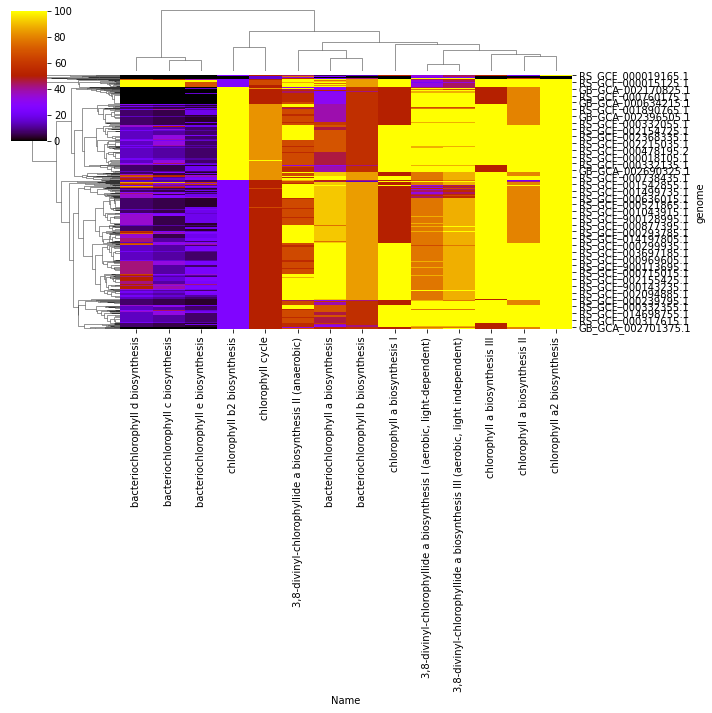

In [32]:
completeness_heatmap_data = gapseq_tbl[gapseq_tbl.genome.isin(phototroph_list)].set_index(['genome', 'Name'])['Completeness'].unstack()
sns.clustermap(completeness_heatmap_data, 
               cmap='gnuplot')

In [44]:
((completeness_heatmap_data > 99).sum(1) > 0).sum()

668

In [38]:
668 / 698

0.9570200573065902

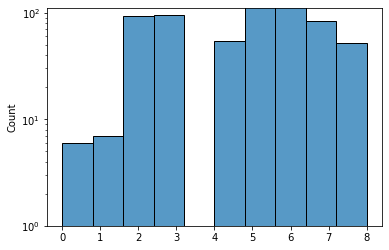

In [191]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot((completeness_heatmap_data == 100).sum(1), bins=10)
ax.set_ylim(1, 110)
ax.set_yscale('log')

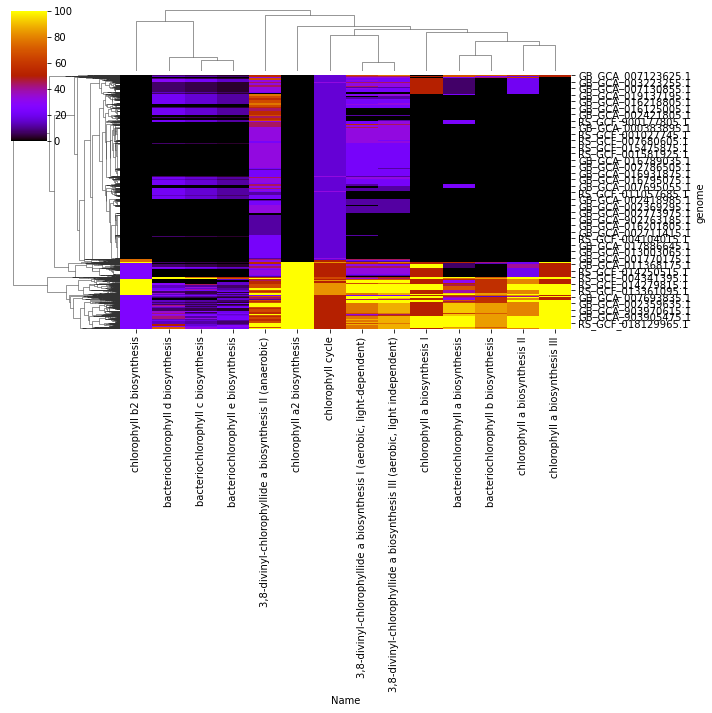

In [192]:
full_heatmap_data = gapseq_tbl.set_index(['genome', 'Name'])['Completeness'].unstack()
sns.clustermap(full_heatmap_data, cmap='gnuplot')

In [120]:
gapseq_tbl

,ID,Name,Prediction,Completeness,VagueReactions,KeyReactions,KeyReactionsFound,ReactionsFound,genome
0,CHLOROPHYLL-SYN,"3,8-divinyl-chlorophyllide a biosynthesis I (a...",True,100,0,2,2,PROTOPORGENOXI-RXN UROGENDECARBOX-RXN RXN1F-20...,RS_GCF_003838195.1
1,PWY-5064,chlorophyll a biosynthesis II,True,100,0,0,0,RXN-7664 RXN-7663 RXN-7665 RXN-7666 RXN-5286,RS_GCF_003838195.1
2,PWY-5068,chlorophyll cycle,True,83,1,0,0,RXN1F-66 RXN-7674 RXN-7676 RXN-7677,RS_GCF_003838195.1
3,PWY-5086,chlorophyll a biosynthesis I,True,100,0,2,2,RXN1F-66 RXN-5286,RS_GCF_003838195.1
4,PWY-5526,bacteriochlorophyll a biosynthesis,False,46,0,0,0,RXN-8788 RXN-8789 RXN-8790 RXN-8791 RXN-5286 R...,RS_GCF_003838195.1
...,...,...,...,...,...,...,...,...,...
9,PWY-7760,bacteriochlorophyll e biosynthesis,False,3,0,4,0,RXN-17491,RS_GCF_000763385.1
10,PWY-7762,bacteriochlorophyll b biosynthesis,False,57,0,1,0,RXN-17480 RXN-17481 RXN-17484 RXN-17482,RS_GCF_000763385.1
11,PWY-7764,chlorophyll a biosynthesis III,True,100,0,1,1,RXN1F-66 RXN-17491,RS_GCF_000763385.1
12,PWY-8126,chlorophyll a2 biosynthesis,True,100,0,0,0,RXN-21286,RS_GCF_000763385.1


In [152]:
gapseq_piv = gapseq_tbl.pivot_table( index='genome', columns='Name', values='Completeness')

In [247]:
gapseq_phototrophs = full_heatmap_data.index[((full_heatmap_data >= 90).sum(1) >= 1)]

In [248]:
gp_count = gtdb_md.loc[gapseq_phototrophs, 'gtdb_taxonomy'].apply(lambda x: x.split(';')[1]).value_counts()
for index, item in gp_count.head(10).iteritems():
    total =  gtdb_md[gtdb_md['gtdb_representative'].eq('t')]['gtdb_taxonomy'].str.contains(index).sum()
    print(item, total)
    print(f"{index}: {item / total * 100:0.2f}%")

1509 17350
p__Proteobacteria: 8.70%
1085 1372
p__Cyanobacteria: 79.08%
660 8588
p__Bacteroidota: 7.69%
57 1387
p__Chloroflexota: 4.11%
42 7328
p__Actinobacteriota: 0.57%
31 238
p__Gemmatimonadota: 13.03%
8 323
p__Firmicutes_B: 2.48%
7 465
p__Myxococcota: 1.51%
4 1334
p__Desulfobacterota: 0.30%
4 873
p__Acidobacteriota: 0.46%


## Checking work - individual taxa

### Chloroflexia

In [249]:
chloroflexia = gtdb_md[gtdb_md['gtdb_taxonomy'].str.contains('p__Chloroflexota') & 
                        gtdb_md['gtdb_representative'].eq('t') & 
                        gtdb_md['gtdb_taxonomy'].str.contains('c__Chloroflexia')].index

non_chloroflexia = gtdb_md[gtdb_md['gtdb_taxonomy'].str.contains('p__Chloroflexota') & 
                        gtdb_md['gtdb_representative'].eq('t') & 
                        ~gtdb_md['gtdb_taxonomy'].str.contains('c__Chloroflexia')].index

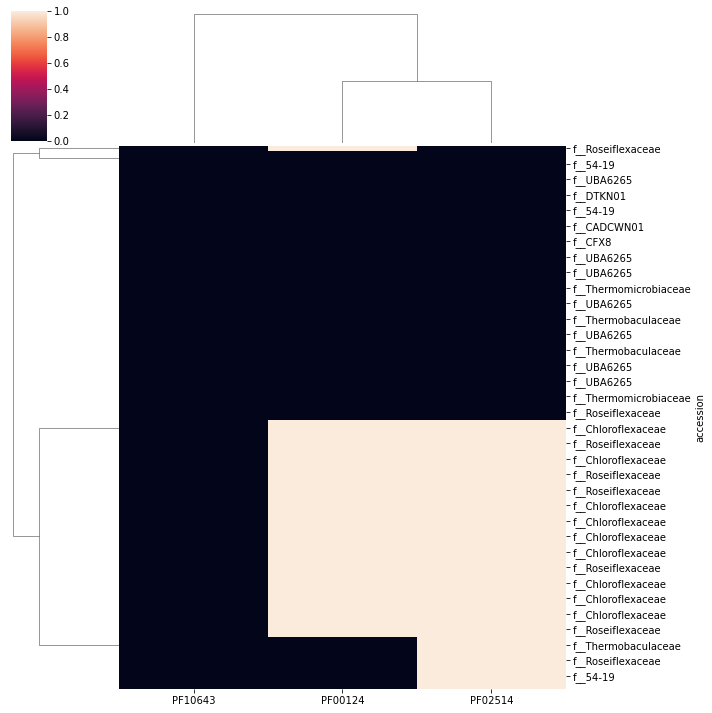

In [250]:
sns.clustermap(all_pfam_data.loc[chloroflexia, ['PF00124', 'PF02514', 'PF10643']].rename(index=gtdb_md.loc[chloroflexia, 'gtdb_taxonomy'].apply(lambda x: x.split(';')[4])))

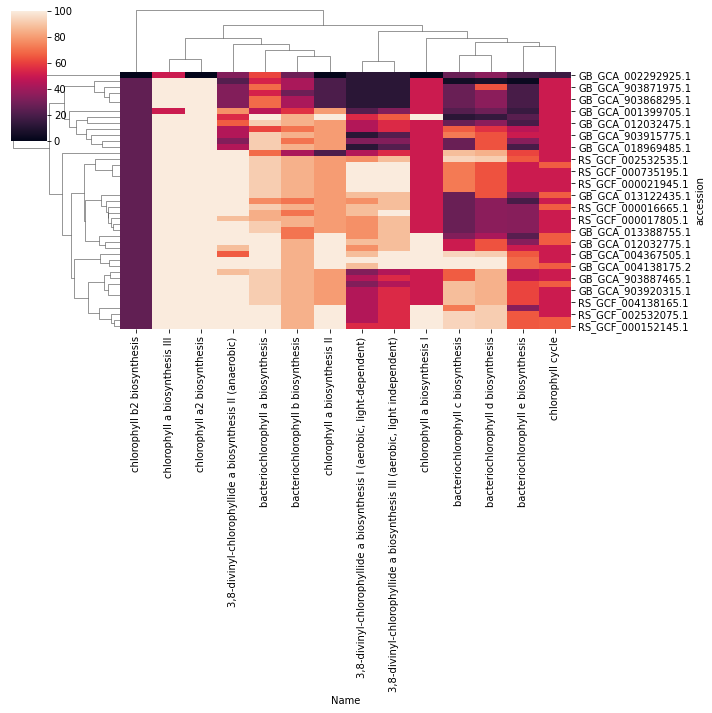

In [251]:
sns.clustermap(gapseq_piv.reindex(index=chloroflexia[all_pfam_data.loc[chloroflexia, 'PF00124'] > 0]).fillna(0))

In [252]:
len(chloroflexia[all_pfam_data.loc[chloroflexia, 'PF00124'] > 0])

43

In [254]:
gtdb_md.loc[gapseq_phototrophs, 'gtdb_taxonomy'].apply(lambda x: x.split(';')[3]).value_counts().loc['o__Chloroflexales']

43

### Cyanobacteria

In [243]:
cyanobacteria = gtdb_md[gtdb_md['gtdb_taxonomy'].str.contains('p__Cyanobacteria') &
                        gtdb_md['gtdb_representative'].eq('t') 
                        # gtdb_md['gtdb_taxonomy'].str.contains('c__Chloroflexia')
                      ].index

In [255]:
total_phototrophs = 0
for cyano_order, count in gtdb_md.loc[cyanobacteria, 'gtdb_taxonomy'].apply(lambda x: x.split(';')[3]).value_counts().head(10).iteritems():
    num_phototrophs = gtdb_md[gtdb_md.gtdb_taxonomy.str.contains(f'{cyano_order};')].index.isin(gapseq_phototrophs).sum()
    total_phototrophs += num_phototrophs
    print(cyano_order, num_phototrophs, num_phototrophs / count)

o__PCC-6307 498 0.9485714285714286
o__Cyanobacteriales 409 0.9951338199513382
o__Gastranaerophilales 0 0.0
o__Phormidesmiales 49 1.0
o__Elainellales 29 1.0
o__Pseudanabaenales 26 0.9629629629629629
o__Obscuribacterales 0 0.0
o__Leptolyngbyales 25 1.0
o__Thermosynechococcales 19 1.0
o__Caenarcaniphilales 0 0.0


In [244]:
total_phototrophs = 0
for cyano_order, count in gtdb_md.loc[cyanobacteria, 'gtdb_taxonomy'].apply(lambda x: x.split(';')[5]).value_counts().head(10).iteritems():
    num_phototrophs = gtdb_md[gtdb_md.gtdb_taxonomy.str.contains(f'{cyano_order};')].index.isin(gapseq_phototrophs).sum()
    total_phototrophs += num_phototrophs
    print(cyano_order, num_phototrophs, num_phototrophs / count)

g__Prochlorococcus_A 258 0.9485294117647058
g__Nostoc 42 1.0
g__Prochlorococcus_B 37 0.9487179487179487
g__CAG-196 0 0.0
g__Synechococcus_C 30 0.967741935483871
g__Synechococcus_E 29 0.9666666666666667
g__Nodosilinea 21 1.0
g__Cyanobium 20 1.0
g__Zag111 0 0.0
g__Pseudanabaena 19 1.0


In [245]:
len(cyanobacteria), total_phototrophs, total_phototrophs / len(cyanobacteria)

(1372, 456, 0.3323615160349854)

### Proteobacteria

In [259]:
proteobacteria = gtdb_md[gtdb_md['gtdb_taxonomy'].str.contains('p__Proteobacteria') &
                        gtdb_md['gtdb_representative'].eq('t') 
                        # gtdb_md['gtdb_taxonomy'].str.contains('c__Chloroflexia')
                      ].index

In [263]:
total_phototrophs = 0
for cyano_order, count in gtdb_md.loc[proteobacteria, 'gtdb_taxonomy'].apply(lambda x: x.split(';')[5]).value_counts().head(30).iteritems():
    num_phototrophs = gtdb_md[gtdb_md.gtdb_taxonomy.str.contains(f'{cyano_order};')].index.isin(gapseq_phototrophs).sum()
    total_phototrophs += num_phototrophs
    print(cyano_order, num_phototrophs, num_phototrophs / count)

g__Pelagibacter 0 0.0
g__Pseudomonas_E 0 0.0
g__Sphingomonas 31 0.15422885572139303
g__Bradyrhizobium 20 0.10582010582010581
g__Vibrio 0 0.0
g__Acinetobacter 0 0.0
g__Rhizobium 0 0.0
g__Polynucleobacter 50 0.37037037037037035
g__Pelagibacter_A 0 0.0
g__Mesorhizobium 1 0.007518796992481203
g__Halomonas 0 0.0
g__Paraburkholderia 0 0.0
g__Novosphingobium 27 0.23478260869565218
g__Rhodoferax 19 0.17272727272727273
g__Enterousia 0 0.0
g__AG-337-I02 0 0.0
g__Pseudoalteromonas 0 0.0
g__Brevundimonas 8 0.0851063829787234
g__Marinobacter 0 0.0
g__Psychrobacter 0 0.0
g__Shewanella 0 0.0
g__Paracoccus 0 0.0
g__Stenotrophomonas 0 0.0
g__Sphingobium 1 0.012987012987012988
g__Methylobacterium 73 0.9605263157894737
g__Variovorax 3 0.041666666666666664
g__Erythrobacter 50 0.7575757575757576
g__Burkholderia 0 0.0
g__Sphingopyxis 1 0.016129032258064516
g__Lysobacter 0 0.0


### Bacteroidota

In [264]:
bacteroidota = gtdb_md[gtdb_md['gtdb_taxonomy'].str.contains('p__Bacteroidota') &
                        gtdb_md['gtdb_representative'].eq('t') 
                        # gtdb_md['gtdb_taxonomy'].str.contains('c__Chloroflexia')
                      ].index

In [266]:
total_phototrophs = 0
for cyano_order, count in gtdb_md.loc[bacteroidota, 'gtdb_taxonomy'].apply(lambda x: x.split(';')[5]).value_counts().head(30).iteritems():
    num_phototrophs = gtdb_md[gtdb_md.gtdb_taxonomy.str.contains(f'{cyano_order};')].index.isin(gapseq_phototrophs).sum()
    total_phototrophs += num_phototrophs
    print(cyano_order, num_phototrophs, num_phototrophs / count)

g__Prevotella 0 0.0
g__Flavobacterium 1 0.002531645569620253
g__Cryptobacteroides 0 0.0
g__Alistipes 0 0.0
g__RF16 0 0.0
g__Chryseobacterium 0 0.0
g__Pedobacter 0 0.0
g__UBA4372 0 0.0
g__Mucilaginibacter 27 0.2755102040816326
g__Bacteroides 0 0.0
g__CAG-485 0 0.0
g__Sodaliphilus 0 0.0
g__Limimorpha 0 0.0
g__Hymenobacter 28 0.34146341463414637
g__UBA1711 0 0.0
g__Sediminibacterium 19 0.25
g__Sphingobacterium 0 0.0
g__Chitinophaga 4 0.057971014492753624
g__Alloprevotella 0 0.0
g__Chlorobium 66 1.0
g__CAG-873 0 0.0
g__Phocaeicola 0 0.0
g__Flavipsychrobacter 14 0.2413793103448276
g__Winogradskyella 0 0.0
g__HGM04593 0 0.0
g__PHOS-HE28 0 0.0
g__Muricauda 0 0.0
g__Ferruginibacter 8 0.16666666666666666
g__Blattabacterium 0 0.0
g__Polaribacter 0 0.0


### Actinobacteria

In [270]:
actinobacteria = gtdb_md[gtdb_md['gtdb_taxonomy'].str.contains('p__Actinobacteriota') &
                        gtdb_md['gtdb_representative'].eq('t') 
                        # gtdb_md['gtdb_taxonomy'].str.contains('c__Chloroflexia')
                      ].index

In [271]:
total_phototrophs = 0
for cyano_order, count in gtdb_md.loc[actinobacteria, 'gtdb_taxonomy'].apply(lambda x: x.split(';')[5]).value_counts().head(30).iteritems():
    num_phototrophs = gtdb_md[gtdb_md.gtdb_taxonomy.str.contains(f'{cyano_order};')].index.isin(gapseq_phototrophs).sum()
    total_phototrophs += num_phototrophs
    print(cyano_order, num_phototrophs, num_phototrophs / count)

g__Streptomyces 0 0.0
g__Collinsella 0 0.0
g__Mycobacterium 0 0.0
g__Microbacterium 0 0.0
g__Corynebacterium 0 0.0
g__Nocardioides 0 0.0
g__Nocardia 0 0.0
g__Micromonospora 7 0.056451612903225805
g__Bifidobacterium 0 0.0
g__Planktophila 0 0.0
g__Cellulomonas 0 0.0
g__Amycolatopsis 0 0.0
g__RAAP-2 0 0.0
g__Spirillospora 1 0.017857142857142856
g__Pseudarthrobacter 0 0.0
g__Rhodococcus 0 0.0
g__Actinoplanes 17 0.32075471698113206
g__Gordonia 0 0.0
g__Curtobacterium 0 0.0
g__Actinomyces 0 0.0
g__Actinomarina 0 0.0
g__Nonomuraea 0 0.0
g__Leucobacter 0 0.0
g__Cryobacterium 0 0.0
g__Kitasatospora 0 0.0
g__Brevibacterium 0 0.0
g__Pseudonocardia 0 0.0
g__Agromyces 0 0.0
g__Pauljensenia 0 0.0
g__Arthrobacter_D 0 0.0


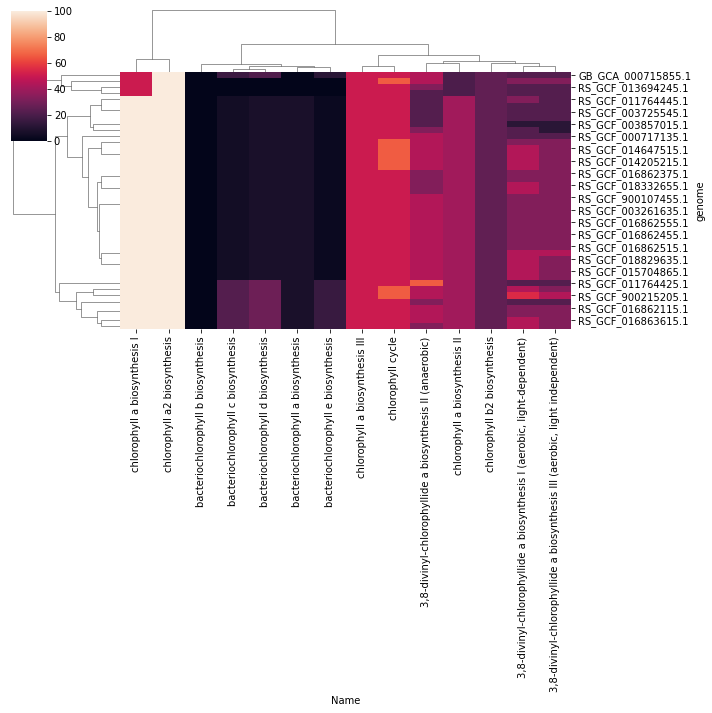

In [275]:
sns.clustermap(full_heatmap_data.loc[[s for s in actinobacteria if s in gapseq_phototrophs], :])

### Myxococcus

In [276]:
myxococcus = gtdb_md[gtdb_md['gtdb_taxonomy'].str.contains('p__Myxococcota') &
                        gtdb_md['gtdb_representative'].eq('t') 
                        # gtdb_md['gtdb_taxonomy'].str.contains('c__Chloroflexia')
                      ].index

In [277]:
total_phototrophs = 0
for cyano_order, count in gtdb_md.loc[myxococcus, 'gtdb_taxonomy'].apply(lambda x: x.split(';')[5]).value_counts().head(30).iteritems():
    num_phototrophs = gtdb_md[gtdb_md.gtdb_taxonomy.str.contains(f'{cyano_order};')].index.isin(gapseq_phototrophs).sum()
    total_phototrophs += num_phototrophs
    print(cyano_order, num_phototrophs, num_phototrophs / count)

g__Myxococcus 0 0.0
g__Corallococcus 0 0.0
g__JABFXX01 0 0.0
g__Fen-1137 0 0.0
g__SXON01 0 0.0
g__UBA2376 0 0.0
g__UBA4248 0 0.0
g__40CM-4-68-19 0 0.0
g__SXRM01 0 0.0
g__CAIYBN01 0 0.0
g__JAAZOP01 0 0.0
g__Archangium 0 0.0
g__UBA4427 0 0.0
g__SLJM01 0 0.0
g__SG8-38 0 0.0
g__CAIUMM01 0 0.0
g__Labilithrix 0 0.0
g__CAITIQ01 1 0.25
g__Nannocystis 0 0.0
g__Lujinxingia 0 0.0
g__Polyangium 0 0.0
g__Sorangium 0 0.0
g__Anaeromyxobacter 0 0.0
g__Fen-1118 0 0.0
g__Ga0077539 0 0.0
g__Stigmatella 0 0.0
g__HGW-17 0 0.0
g__WRKR01 0 0.0
g__Ga0077550 2 0.6666666666666666
g__JAZXM01 0 0.0


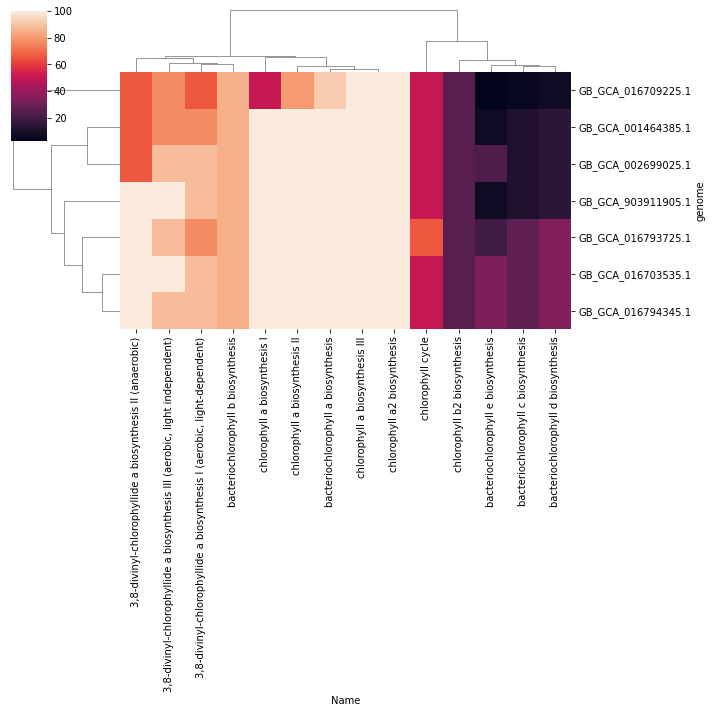

In [278]:
sns.clustermap(full_heatmap_data.loc[[s for s in myxococcus if s in gapseq_phototrophs], :])

## Saving data

In [288]:
phototroph_save_data = pd.Series(index=gtdb_md[gtdb_md.gtdb_representative.eq('t')].index, data=[s in gapseq_phototrophs for s in gtdb_md[gtdb_md.gtdb_representative.eq('t')].index])

In [290]:
phototroph_save_data.to_csv('/data/mhoffert/fiererlab/periodic_phyla/results/full_gtdb_photosynthesis_predictions_v2.tsv.gz', sep='\t', compression='gzip')